In [1]:
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fontTools.ttLib import TTFont
from fontTools.ttLib.ttCollection import TTCollection


In [2]:
def get_font_dirs():
    font_dirs = []
    system = platform.system()

    if system == "Windows":
        font_dirs.extend(
            [
                os.path.join(os.environ["WINDIR"], "Fonts"),
                os.path.join(
                    os.environ["LOCALAPPDATA"], "Microsoft", "Windows", "Fonts"
                ),
            ]
        )
    elif system == "Darwin":
        font_dirs.extend(
            [
                "/Library/Fonts",
                "/System/Library/Fonts",
                os.path.expanduser("~/Library/Fonts"),
            ]
        )
    elif system == "Linux":
        font_dirs.extend(
            [
                "/usr/share/fonts",
                "/usr/local/share/fonts",
                os.path.expanduser("~/.fonts"),
                os.path.expanduser("~/.local/share/fonts"),
            ]
        )

    return [dir for dir in font_dirs if os.path.isdir(dir)]


font_dirs = get_font_dirs()
font_dirs


['C:\\WINDOWS\\Fonts',
 'C:\\Users\\fjktk\\AppData\\Local\\Microsoft\\Windows\\Fonts']

In [3]:
def get_font_files(dir):
    font_files = []
    font_extensions = {".ttf", ".otf", ".ttc"}

    for root, _, files in os.walk(dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in font_extensions):
                font_files.append(os.path.join(root, file))

    return font_files


font_files = [file for dir in font_dirs for file in get_font_files(dir)]
font_files


['C:\\WINDOWS\\Fonts\\arial.ttf',
 'C:\\WINDOWS\\Fonts\\arialbd.ttf',
 'C:\\WINDOWS\\Fonts\\arialbi.ttf',
 'C:\\WINDOWS\\Fonts\\ariali.ttf',
 'C:\\WINDOWS\\Fonts\\ARIALN.TTF',
 'C:\\WINDOWS\\Fonts\\ARIALNB.TTF',
 'C:\\WINDOWS\\Fonts\\ARIALNBI.TTF',
 'C:\\WINDOWS\\Fonts\\ARIALNI.TTF',
 'C:\\WINDOWS\\Fonts\\ariblk.ttf',
 'C:\\WINDOWS\\Fonts\\bahnschrift.ttf',
 'C:\\WINDOWS\\Fonts\\BIZ-UDGothicB.ttc',
 'C:\\WINDOWS\\Fonts\\BIZ-UDGothicR.ttc',
 'C:\\WINDOWS\\Fonts\\BIZ-UDMinchoM.ttc',
 'C:\\WINDOWS\\Fonts\\Caladea-Bold.ttf',
 'C:\\WINDOWS\\Fonts\\Caladea-BoldItalic.ttf',
 'C:\\WINDOWS\\Fonts\\Caladea-Italic.ttf',
 'C:\\WINDOWS\\Fonts\\Caladea-Regular.ttf',
 'C:\\WINDOWS\\Fonts\\calibri.ttf',
 'C:\\WINDOWS\\Fonts\\calibrib.ttf',
 'C:\\WINDOWS\\Fonts\\calibrii.ttf',
 'C:\\WINDOWS\\Fonts\\calibril.ttf',
 'C:\\WINDOWS\\Fonts\\calibrili.ttf',
 'C:\\WINDOWS\\Fonts\\calibriz.ttf',
 'C:\\WINDOWS\\Fonts\\cambria.ttc',
 'C:\\WINDOWS\\Fonts\\cambriab.ttf',
 'C:\\WINDOWS\\Fonts\\cambriai.ttf',
 'C:\\W

In [4]:
def get_ttfont(file):
    try:
        return [TTFont(file)]
    except Exception:
        try:
            collection = TTCollection(file)
            return collection.fonts
        except Exception as e:
            print(f"Error processing {file}: {e}")
            return []


ttfont_list = [ttfont for file in font_files for ttfont in get_ttfont(file)]


In [5]:
def safe_get_name(ttfont, nameID, platformID=3, langID=1033):
    try:
        for record in ttfont["name"].names:
            if (
                record.nameID == nameID
                and record.platformID == platformID
                and record.langID == langID
            ):
                return record.toStr()
    except Exception as e:
        print(f"Error reading nameID {nameID}: {e}")
    return "Unknown"


In [6]:
selected_fonts = [
    "ArialMT",
    "BIZ-UDGothic",
    "BIZ-UDMincho-Medium",
    "Calibri",
    "Cambria",
    "CMUSansSerif",
    "Consolas",
    "DejaVuSerif",
    "Georgia",
    "Impact",
    "IPAexGothic",
    "IPAexMincho",
    "LINESeedJP_OTF-Regular",
    "Meiryo",
    "mgenplus-1mn-regular",
    "MS-Gothic",
    "MS-Mincho",
    "Rockwell",
    "SegoeUI",
    "TimesNewRomanPSMT",
    "Tahoma",
    "Verdana",
    "YuGothic-Regular",
    "YuMincho-Regular",
    "FOT_DNPShueiMinPr6N-B",
    "NewRodinProN-B",
    "TsukuGoPro-R",
    "TsukuMinPr6N-R",
    "UDKakugo_LargePr6N-R",
    "UDShinGoPr6N-Regular",
    "NotoSansJP-Regular",
    "PRyuminPr6N-Regular",
    "HiraginoSerifPr6N-W3",
    "HiraginoSansPr6N-W3",
]

filtered_ttfont_list = [
    ttfont for ttfont in ttfont_list if safe_get_name(ttfont, 6) in selected_fonts
]


In [7]:
def count_glyphs(ttfont):
    try:
        glyph_set = ttfont.getGlyphSet()
        return len(glyph_set.keys())
    except Exception as e:
        print(f"Error processing glyf table: {e}")
        return 0


In [8]:
from fontTools.pens.basePen import BasePen


class NodeCountPen(BasePen):
    def __init__(self, glyphSet):
        super().__init__(glyphSet)
        self.node_count = 0

    def _moveTo(self, p0):
        self.node_count += 1

    def _lineTo(self, p1):
        self.node_count += 1

    def _qCurveToOne(self, p1, p2):
        self.node_count += 1

    def _curveToOne(self, p1, p2, p3):
        self.node_count += 1

    def _closePath(self):
        pass

    def _endPath(self):
        pass


def get_glyph_complexity(ttfont):
    total_nodes = 0
    glyph_count = 0
    glyph_set = ttfont.getGlyphSet()

    for glyph_name in glyph_set.keys():
        pen = NodeCountPen(glyph_set)
        glyph = glyph_set[glyph_name]
        glyph.draw(pen)
        glyph_node_count = pen.node_count

        if glyph_node_count > 0:
            glyph_count += 1
            total_nodes += glyph_node_count

    if glyph_count == 0:
        return 0

    return total_nodes / glyph_count


In [9]:
def get_font_info(ttfont):
    postscript_name = safe_get_name(ttfont, 6)
    glyph_count = count_glyphs(ttfont)
    glyph_complexity = get_glyph_complexity(ttfont)
    return (postscript_name, glyph_count, glyph_complexity)


font_info_list = [get_font_info(ttfont) for ttfont in filtered_ttfont_list]


In [10]:
df = pd.DataFrame(
    font_info_list, columns=["PostScript Name", "Glyph Count", "Glyph Complexity"]
)
df


,PostScript Name,Glyph Count,Glyph Complexity
0,ArialMT,4548,25.658011
1,BIZ-UDGothic,13811,56.035950
2,BIZ-UDMincho-Medium,13811,77.456114
3,Calibri,7042,61.517829
4,Cambria,7614,33.464587
5,CMUSansSerif,684,25.384036
6,Consolas,3030,29.920730
7,DejaVuSerif,3528,28.267878
8,Georgia,864,38.564460
9,Impact,1019,24.318540


In [49]:
import matplotlib.font_manager

font_files = matplotlib.font_manager.findSystemFonts()

font_names = sorted(
    {
        matplotlib.font_manager.FontProperties(fname=font).get_name()
        for font in font_files
    }
)

for font_name in font_names:
    print(font_name)


Arial
BIZ UDGothic
BIZ UDMincho
Bahnschrift
CMU Bright
CMU Classical Serif
CMU Concrete
CMU Sans Serif
CMU Sans Serif Demi Condensed
CMU Serif
CMU Serif Extra
CMU Serif Upright Italic
CMU Typewriter Text
CMU Typewriter Text Variable Width
Caladea
Calibri
Cambria
Candara
Carlito
Cascadia Code
Cascadia Mono
Comic Sans MS
Consolas
Constantia
Corbel
Courier New
DejaVu Sans
DejaVu Sans Mono
DejaVu Serif
Ebrima
FOT-Akakane Std
FOT-Anito Std
FOT-AnticCezanne Pro
FOT-Aokane Std
FOT-Aralet Std
FOT-BabyPop Std
FOT-Budo Std
FOT-Carat Std
FOT-Cezanne ProN
FOT-CezanneBokutoh Pro
FOT-Chiaro Std
FOT-Comet Std
FOT-ComicMystery Std
FOT-ComicReggae Std
FOT-CookHand Std
FOT-Cuckoo Std
FOT-DNP ShueiAntiStd
FOT-DNP ShueiGoGinStd
FOT-DNP ShueiGoKinStd
FOT-DNP ShueiMGoStd
FOT-DNP ShueiYMinStd
FOT-DNPShuei4goBStd
FOT-DNPShuei4goStd
FOT-DNPShueiMinPr6N
FOT-DNPShueiShogoMinStd
FOT-DotGothic12 Std
FOT-DotGothic16 Std
FOT-DotMincho12 Std
FOT-DotMincho16 Std
FOT-GMaruGo Pro
FOT-Gospel Std
FOT-Greco Std
FOT-HaruNag

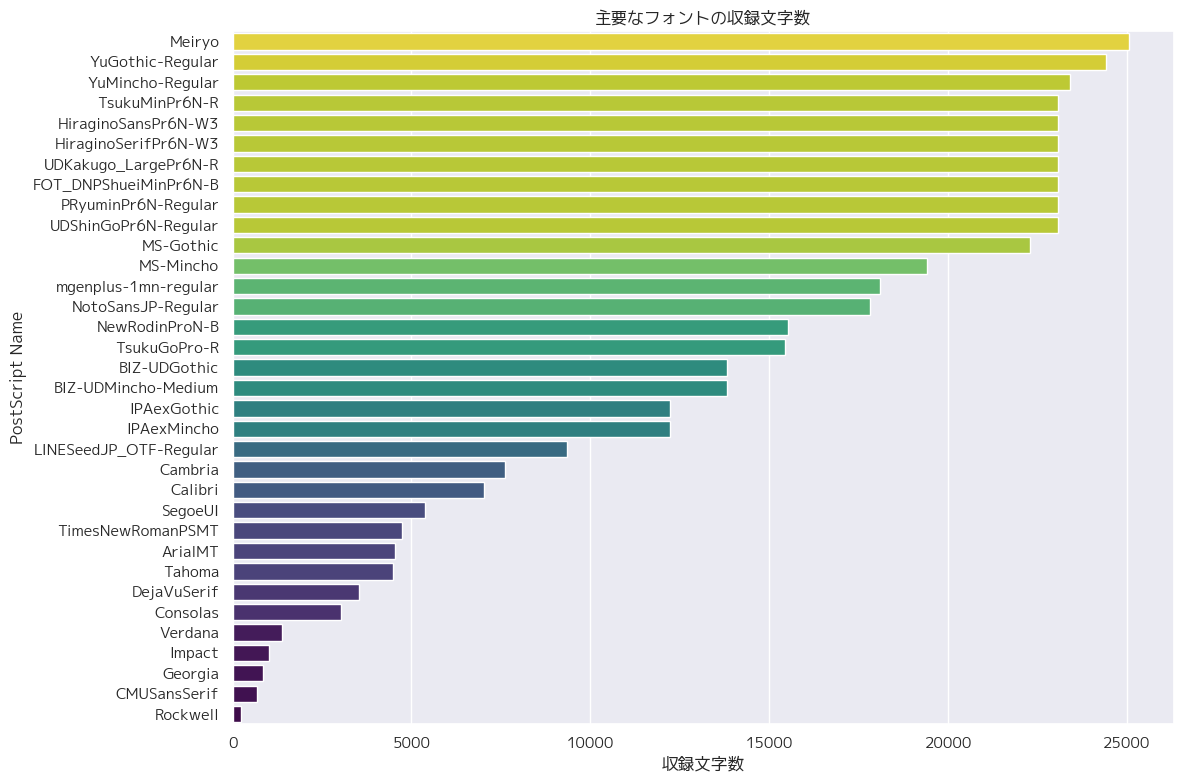

In [47]:
df = df.sort_values(by="Glyph Count", ascending=False)

plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid", font="Mgen+ 1p")
sns.barplot(
    x="Glyph Count",
    y="PostScript Name",
    hue="Glyph Count",
    data=df,
    palette="viridis",
    dodge=False,
    legend=False,
)
plt.title("主要なフォントの収録文字数")
plt.xlabel("収録文字数")
plt.ylabel("PostScript Name")
plt.tight_layout()
plt.savefig("glyph_counts.pdf", format="pdf")
plt.show()


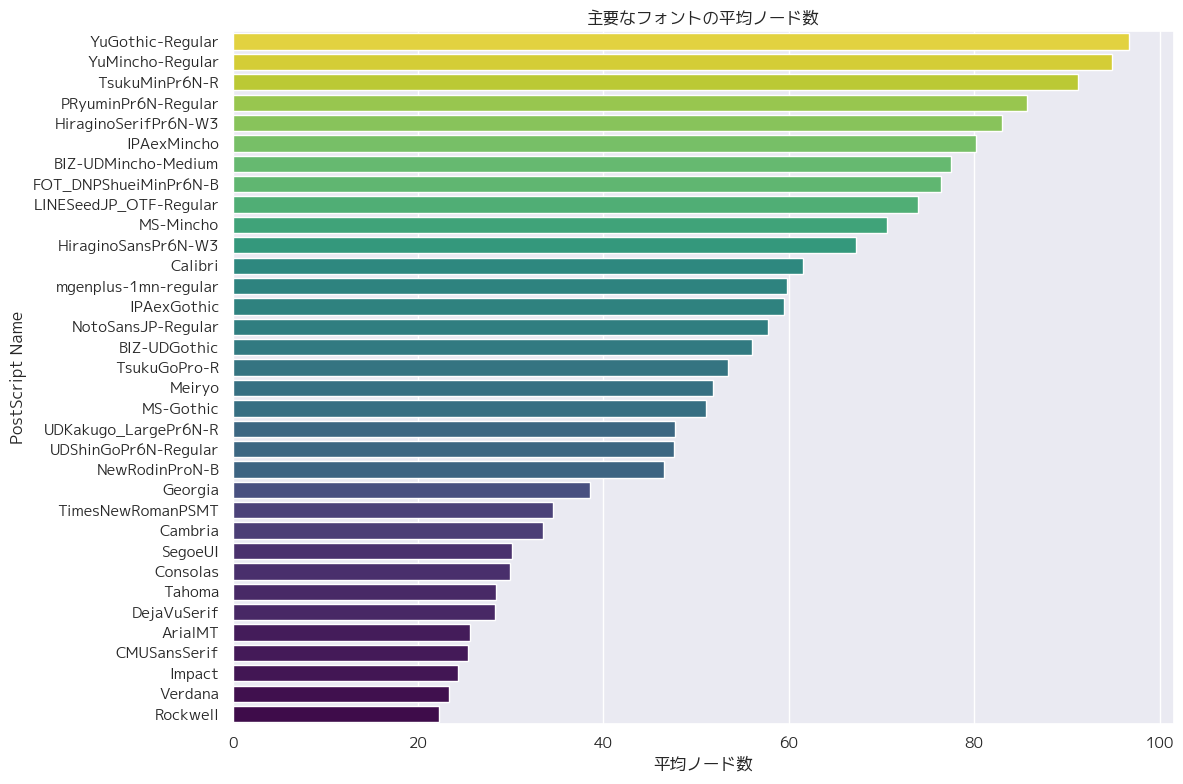

In [48]:
df = df.sort_values(by="Glyph Complexity", ascending=False)

plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid", font="Mgen+ 1p")
sns.barplot(
    x="Glyph Complexity",
    y="PostScript Name",
    hue="Glyph Complexity",
    data=df,
    palette="viridis",
    dodge=False,
    legend=False,
)
plt.title("主要なフォントの平均ノード数")
plt.xlabel("平均ノード数")
plt.ylabel("PostScript Name")
plt.tight_layout()
plt.savefig("glyph_complexity.pdf", format="pdf")
plt.show()
